# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

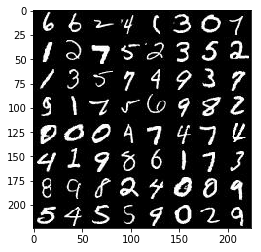

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

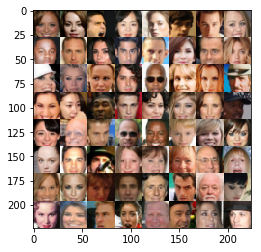

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real')
    
    inputs_z = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # hidden layer with n_units proportional to 28*28 i.e. the image size on a channel
        n_units = 784
        h1 = tf.layers.dense(images, n_units, activation=None)
        
        # leaky ReLU with alpha 0.2
        h1 = tf.maximum(0.2 * h1, h1)
        
        # flatten and outputs
        shape = h1.get_shape().as_list()    
        dim = np.prod(shape[1:])
        h1 = tf.reshape(h1, [-1, dim])
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # hidden layer with n_units proportional to 28*28 i.e. the image size on a channel
        n_units = 784
        h1 = tf.layers.dense(z, n_units, activation=None)
        
        # leaky ReLU with alpha 0.2
        h1 = tf.maximum(0.2 * h1, h1)
        
        # reshape and outputs
        h1 = tf.reshape(h1, [-1, 28, 28, out_channel_dim])
        logits = tf.layers.dense(h1, out_channel_dim, activation=None)
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # model   
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
import pickle
from time import gmtime, strftime

def show_save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    pickle.dump(samples, open('gan_samples_%s_%s.pkl'%(image_mode, strftime("%Y-%m-%dT%H.%M.%S", gmtime())), 'wb'))

In [12]:
def plot_generator_sample(pkl):
    image_mode = pkl.split('_')[2]
    samples = pickle.load(pkl, 'rb')
    cmap = None if image_mode == 'RGB' else 'gray'
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """   
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
        
    #image_width, image_height, image_channels from data_shape
    input_real, input_z, learning_rate_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_placeholder, beta1)
    #print('input real placeholder shape:', input_real.shape)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers, rescale images for G and D
                #print('batch images shape: ', batch_images.shape)
                # batch_images = batch_images*2 - 1
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_placeholder: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     learning_rate_placeholder: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode)
                    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 5.0180
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 5.1882
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 3.9198
Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 6.1291
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 4.4672
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 5.7288
Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 5.8196
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 3.7391
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 4.3733
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 3.1292


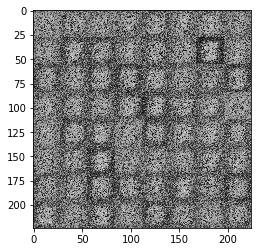

Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 5.8776
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 3.7078
Epoch 1/2... Discriminator Loss: 0.4746... Generator Loss: 3.2443
Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 4.1754
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 4.1458
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 2.9603
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 3.2103
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 2.7629
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 3.4056
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.9676


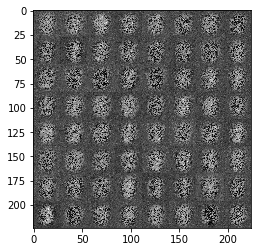

Epoch 1/2... Discriminator Loss: 0.4855... Generator Loss: 3.0078
Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 3.3777
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 5.1618
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 2.1984
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 4.0446
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 3.4598
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 3.9058
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 3.2374
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 5.7281
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 2.9430


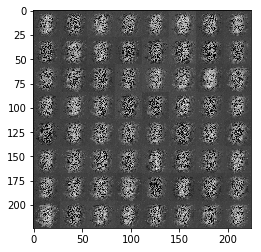

Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 3.3787
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 3.1800
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 4.1091
Epoch 1/2... Discriminator Loss: 0.3882... Generator Loss: 4.3469
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 3.6669
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 5.6336
Epoch 1/2... Discriminator Loss: 0.5320... Generator Loss: 4.1004
Epoch 1/2... Discriminator Loss: 0.4186... Generator Loss: 4.2415
Epoch 1/2... Discriminator Loss: 0.4131... Generator Loss: 3.7574
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 3.6494


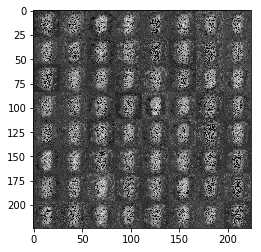

Epoch 1/2... Discriminator Loss: 0.3650... Generator Loss: 4.1663
Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 4.2595
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 5.6836
Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 4.2678
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 4.6170
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 3.8443
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 2.2101
Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 3.4361
Epoch 1/2... Discriminator Loss: 2.3751... Generator Loss: 0.3126


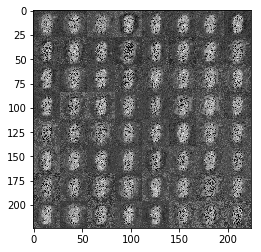

Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 4.6493
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 5.6324
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 4.0846
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 3.2873
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 3.8667
Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 4.1236
Epoch 1/2... Discriminator Loss: 0.4034... Generator Loss: 3.2577
Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 4.0776
Epoch 1/2... Discriminator Loss: 5.9973... Generator Loss: 0.0094
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 2.3650


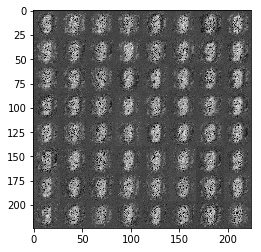

Epoch 1/2... Discriminator Loss: 0.4189... Generator Loss: 3.3134
Epoch 1/2... Discriminator Loss: 0.3941... Generator Loss: 3.5092
Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 3.2588
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 4.3173
Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 3.4893
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 4.5369
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.6456
Epoch 1/2... Discriminator Loss: 0.3656... Generator Loss: 3.6039
Epoch 1/2... Discriminator Loss: 0.3609... Generator Loss: 4.3739
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 2.4016


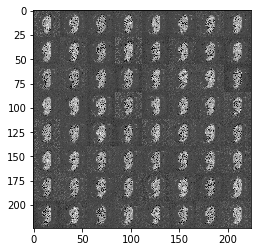

Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 4.2732
Epoch 1/2... Discriminator Loss: 0.5237... Generator Loss: 2.5109
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.9064
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 6.9590
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 5.3746
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 4.6540
Epoch 1/2... Discriminator Loss: 0.3777... Generator Loss: 4.0922
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 3.4681
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.9913
Epoch 1/2... Discriminator Loss: 0.3735... Generator Loss: 4.4803


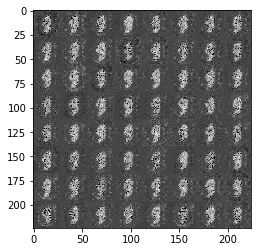

Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 4.2507
Epoch 1/2... Discriminator Loss: 0.3964... Generator Loss: 3.3513
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 3.4969
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 3.6843
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 2.0224
Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 4.1816
Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 4.5258
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.4898
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 2.5959
Epoch 1/2... Discriminator Loss: 0.3752... Generator Loss: 3.7073


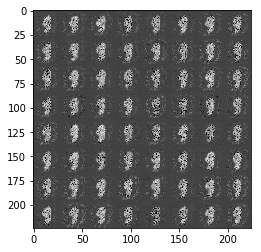

Epoch 1/2... Discriminator Loss: 0.4067... Generator Loss: 4.5792
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 4.5697
Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 9.0852
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 5.4012
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.8574
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 2.0470
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 4.4794
Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 2.7669
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 4.0694
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 3.4336


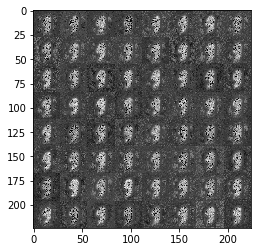

Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 4.1900
Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 3.8835
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 2.0350
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 4.6915
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 4.3811
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 3.5989
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 4.1200
Epoch 1/2... Discriminator Loss: 0.3877... Generator Loss: 3.5533
Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 4.1934
Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 3.8378


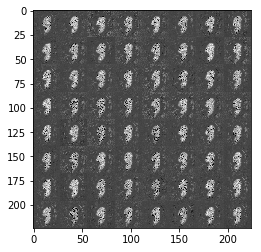

Epoch 1/2... Discriminator Loss: 0.3874... Generator Loss: 3.9478
Epoch 1/2... Discriminator Loss: 0.3874... Generator Loss: 3.8705
Epoch 1/2... Discriminator Loss: 0.3904... Generator Loss: 4.2986
Epoch 1/2... Discriminator Loss: 0.3932... Generator Loss: 4.2192
Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 4.6083
Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 3.0984
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 2.8629
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 3.9263
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 3.8675
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 4.0997


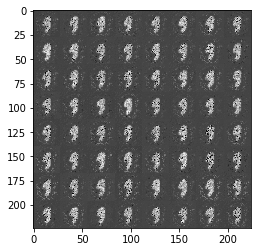

Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 4.3250
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 3.9248
Epoch 1/2... Discriminator Loss: 0.4508... Generator Loss: 5.3596
Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 3.3820
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 6.8940
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 3.8305
Epoch 1/2... Discriminator Loss: 0.3882... Generator Loss: 4.0547
Epoch 1/2... Discriminator Loss: 0.4867... Generator Loss: 3.0383
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 4.1884
Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 2.8022


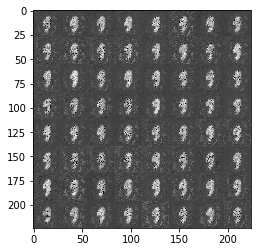

Epoch 1/2... Discriminator Loss: 0.4248... Generator Loss: 4.3577
Epoch 1/2... Discriminator Loss: 0.5349... Generator Loss: 2.4852
Epoch 1/2... Discriminator Loss: 0.3957... Generator Loss: 4.0696
Epoch 1/2... Discriminator Loss: 0.4206... Generator Loss: 3.8281
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 3.7628
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 3.2235
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 4.7515
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 4.4730
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 3.3270
Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 4.5622


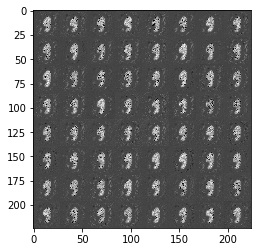

Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 3.6662
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 4.0468
Epoch 1/2... Discriminator Loss: 0.4112... Generator Loss: 3.3299
Epoch 1/2... Discriminator Loss: 0.5224... Generator Loss: 3.6097
Epoch 1/2... Discriminator Loss: 0.4239... Generator Loss: 4.8061
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 3.4553
Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 4.4798
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 4.3694
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 4.1830
Epoch 1/2... Discriminator Loss: 0.4206... Generator Loss: 3.6546


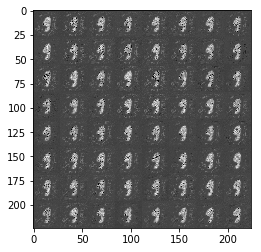

Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 4.3438
Epoch 1/2... Discriminator Loss: 2.0237... Generator Loss: 9.5638
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 5.9678
Epoch 1/2... Discriminator Loss: 0.4690... Generator Loss: 4.0730
Epoch 1/2... Discriminator Loss: 0.4157... Generator Loss: 3.9344
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 5.1529
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 4.2816
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 10.3238
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 6.2075
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 3.9590


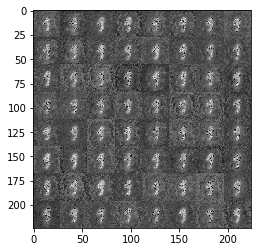

Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 4.8367
Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 3.9770
Epoch 1/2... Discriminator Loss: 0.4961... Generator Loss: 3.3697
Epoch 1/2... Discriminator Loss: 0.4344... Generator Loss: 4.5490
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 5.3897
Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 4.8561
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 3.6253
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 2.6480
Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 3.9640
Epoch 1/2... Discriminator Loss: 0.3914... Generator Loss: 4.5440


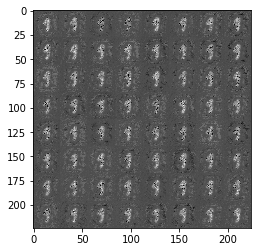

Epoch 1/2... Discriminator Loss: 0.4014... Generator Loss: 3.7040
Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 4.5328
Epoch 1/2... Discriminator Loss: 0.4332... Generator Loss: 4.1751
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 3.8385
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 4.2409
Epoch 1/2... Discriminator Loss: 0.4247... Generator Loss: 4.0731
Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 3.4379
Epoch 1/2... Discriminator Loss: 0.4021... Generator Loss: 3.5555
Epoch 1/2... Discriminator Loss: 0.4730... Generator Loss: 2.8777
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 3.5993


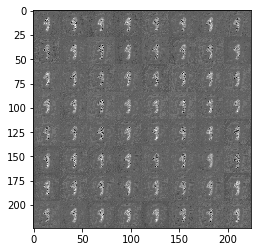

Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 3.1545
Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 3.2446
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 3.2332
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 3.6416
Epoch 1/2... Discriminator Loss: 0.4781... Generator Loss: 3.8014
Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 3.3527
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 3.9151
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 3.2444
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 3.4344
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 2.6137


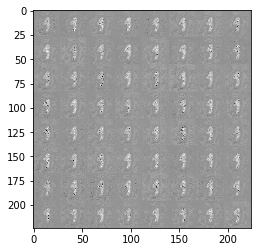

Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 3.7170
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 3.7969
Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 3.8838
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 2.8327
Epoch 2/2... Discriminator Loss: 0.4789... Generator Loss: 4.3114
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 3.6585
Epoch 2/2... Discriminator Loss: 0.4832... Generator Loss: 3.5000
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 3.4446
Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 3.6984
Epoch 2/2... Discriminator Loss: 0.4700... Generator Loss: 3.4529


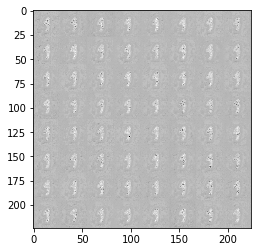

Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 4.1880
Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 3.2998
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 4.0659
Epoch 2/2... Discriminator Loss: 0.4955... Generator Loss: 3.4385
Epoch 2/2... Discriminator Loss: 0.4860... Generator Loss: 3.0934
Epoch 2/2... Discriminator Loss: 0.4422... Generator Loss: 3.2392
Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 4.0236
Epoch 2/2... Discriminator Loss: 0.4618... Generator Loss: 4.4773
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 3.5471
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 3.8082


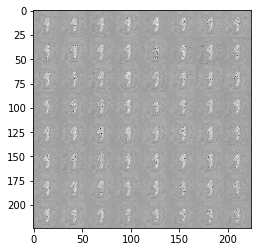

Epoch 2/2... Discriminator Loss: 0.4265... Generator Loss: 3.7151
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 3.5877
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 3.9246
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 3.7995
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 4.1154
Epoch 2/2... Discriminator Loss: 0.4578... Generator Loss: 3.3061
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 3.5956
Epoch 2/2... Discriminator Loss: 0.4585... Generator Loss: 3.0107
Epoch 2/2... Discriminator Loss: 0.4639... Generator Loss: 3.3372
Epoch 2/2... Discriminator Loss: 0.4471... Generator Loss: 3.5771


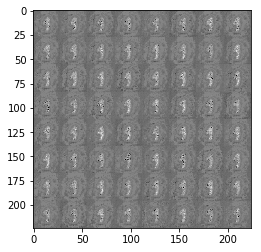

Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 3.6054
Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 3.0021
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 3.6266
Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 3.4890
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 3.7572
Epoch 2/2... Discriminator Loss: 0.4496... Generator Loss: 3.4020
Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 3.6382
Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 3.4705
Epoch 2/2... Discriminator Loss: 0.4452... Generator Loss: 3.4015
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 3.1268


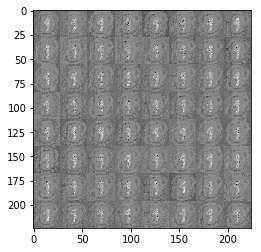

Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 3.3019
Epoch 2/2... Discriminator Loss: 0.4826... Generator Loss: 2.9994
Epoch 2/2... Discriminator Loss: 0.4384... Generator Loss: 4.0569
Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 3.9584
Epoch 2/2... Discriminator Loss: 0.4485... Generator Loss: 3.4894
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 3.4042
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 3.8642
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 3.8555
Epoch 2/2... Discriminator Loss: 0.4145... Generator Loss: 3.6766
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 3.9446


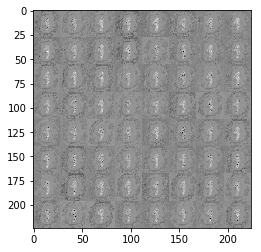

Epoch 2/2... Discriminator Loss: 0.4039... Generator Loss: 3.7622
Epoch 2/2... Discriminator Loss: 0.4352... Generator Loss: 3.2778
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 3.4292
Epoch 2/2... Discriminator Loss: 0.4435... Generator Loss: 3.3486
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 3.9128
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 3.5548
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 4.2073
Epoch 2/2... Discriminator Loss: 0.4518... Generator Loss: 3.4792
Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 3.1017
Epoch 2/2... Discriminator Loss: 0.5144... Generator Loss: 3.2286


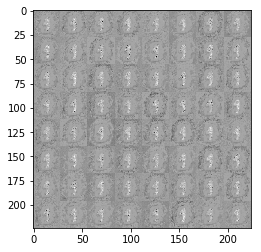

Epoch 2/2... Discriminator Loss: 0.4543... Generator Loss: 3.5158
Epoch 2/2... Discriminator Loss: 0.4135... Generator Loss: 3.8682
Epoch 2/2... Discriminator Loss: 0.4550... Generator Loss: 3.4074
Epoch 2/2... Discriminator Loss: 0.4047... Generator Loss: 3.9759
Epoch 2/2... Discriminator Loss: 0.4665... Generator Loss: 4.0274
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 3.9837
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 3.1328
Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 3.6585
Epoch 2/2... Discriminator Loss: 0.4747... Generator Loss: 4.1413
Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 3.9015


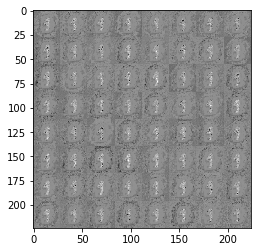

Epoch 2/2... Discriminator Loss: 0.4413... Generator Loss: 3.6803
Epoch 2/2... Discriminator Loss: 0.4129... Generator Loss: 3.6148
Epoch 2/2... Discriminator Loss: 0.4434... Generator Loss: 3.9332
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 3.1966
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 3.7121
Epoch 2/2... Discriminator Loss: 0.4975... Generator Loss: 2.9458
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 3.9797
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 2.7649
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 3.8876
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 4.1576


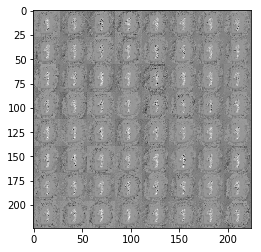

Epoch 2/2... Discriminator Loss: 0.4667... Generator Loss: 4.6201
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 3.4095
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 4.0925
Epoch 2/2... Discriminator Loss: 0.4431... Generator Loss: 3.6738
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 3.7884
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 3.7326
Epoch 2/2... Discriminator Loss: 0.4352... Generator Loss: 3.4534
Epoch 2/2... Discriminator Loss: 0.4001... Generator Loss: 3.4948
Epoch 2/2... Discriminator Loss: 0.3937... Generator Loss: 3.8382


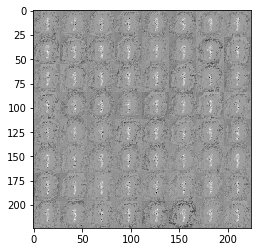

Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 3.6790
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 3.7878
Epoch 2/2... Discriminator Loss: 0.4214... Generator Loss: 3.4639
Epoch 2/2... Discriminator Loss: 0.5551... Generator Loss: 2.6166
Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 2.9922
Epoch 2/2... Discriminator Loss: 0.4148... Generator Loss: 3.7099
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 3.3265
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 3.6716
Epoch 2/2... Discriminator Loss: 0.4698... Generator Loss: 3.1826
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 3.3586


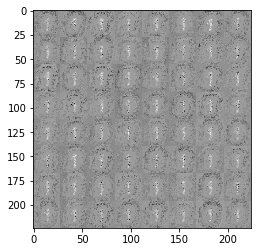

Epoch 2/2... Discriminator Loss: 0.4257... Generator Loss: 3.6847
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 3.6841
Epoch 2/2... Discriminator Loss: 0.4124... Generator Loss: 3.5892
Epoch 2/2... Discriminator Loss: 0.4254... Generator Loss: 3.6019
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 3.6760
Epoch 2/2... Discriminator Loss: 0.6044... Generator Loss: 2.5919
Epoch 2/2... Discriminator Loss: 0.4955... Generator Loss: 2.8826
Epoch 2/2... Discriminator Loss: 0.4367... Generator Loss: 3.7314
Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 4.2035
Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 3.6090


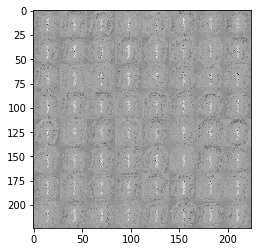

Epoch 2/2... Discriminator Loss: 0.4349... Generator Loss: 3.2255
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 4.2156
Epoch 2/2... Discriminator Loss: 0.4061... Generator Loss: 3.5348
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 2.9625
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 3.8326
Epoch 2/2... Discriminator Loss: 0.4543... Generator Loss: 3.2675
Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 3.3752
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 3.7329
Epoch 2/2... Discriminator Loss: 0.4030... Generator Loss: 3.9729
Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 3.6288


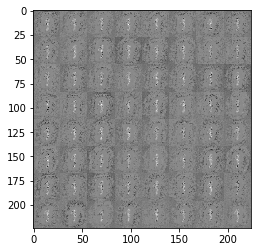

Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 3.0467
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 3.4965
Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 4.0656
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 2.6961
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 3.7757
Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 3.4378
Epoch 2/2... Discriminator Loss: 0.4747... Generator Loss: 3.6084
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 5.1063
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 4.3305
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 3.5784


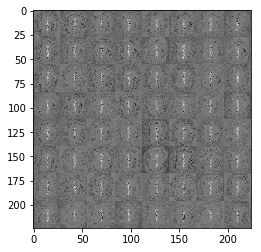

Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 3.8209
Epoch 2/2... Discriminator Loss: 0.5190... Generator Loss: 4.6609
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 5.6715
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 4.3614
Epoch 2/2... Discriminator Loss: 0.4755... Generator Loss: 3.0394
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 4.0461
Epoch 2/2... Discriminator Loss: 0.4205... Generator Loss: 3.6968
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 3.5743
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 3.6309
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 3.4969


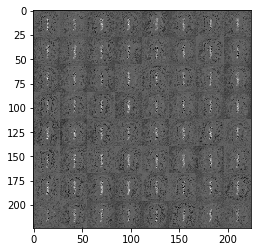

Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 3.7967
Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 3.4546
Epoch 2/2... Discriminator Loss: 0.4039... Generator Loss: 3.1861
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.3819
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 3.4672
Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 3.6655
Epoch 2/2... Discriminator Loss: 0.4216... Generator Loss: 3.1626
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.6196
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 5.3813
Epoch 2/2... Discriminator Loss: 10.5579... Generator Loss: 0.1900


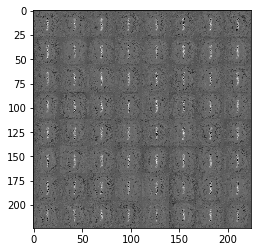

Epoch 2/2... Discriminator Loss: 4.5095... Generator Loss: 7.4180
Epoch 2/2... Discriminator Loss: 5.8463... Generator Loss: 24.6034
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 18.2164
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 23.4556
Epoch 2/2... Discriminator Loss: 2.2778... Generator Loss: 20.5455
Epoch 2/2... Discriminator Loss: 1.8035... Generator Loss: 18.1988
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 12.4122
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 7.5072
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 7.7783
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 6.9331


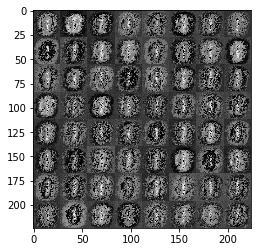

Epoch 2/2... Discriminator Loss: 2.2543... Generator Loss: 11.5165
Epoch 2/2... Discriminator Loss: 1.9184... Generator Loss: 4.3484
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 9.1099
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 7.8964
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 5.5398
Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 7.2492
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 7.8369
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 7.6377
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 4.3599
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 5.5025


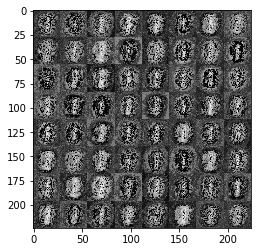

Epoch 2/2... Discriminator Loss: 0.3640... Generator Loss: 6.6575
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 8.2475
Epoch 2/2... Discriminator Loss: 0.3733... Generator Loss: 9.5990
Epoch 2/2... Discriminator Loss: 0.3667... Generator Loss: 7.1958
Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 7.2253
Epoch 2/2... Discriminator Loss: 0.3961... Generator Loss: 5.1629
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 6.5917
Epoch 2/2... Discriminator Loss: 0.3606... Generator Loss: 5.8033
Epoch 2/2... Discriminator Loss: 0.3579... Generator Loss: 5.2141
Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 5.9067


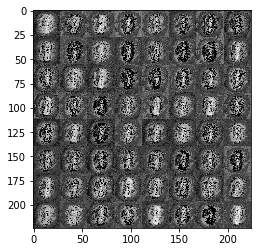

Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 5.6017
Epoch 2/2... Discriminator Loss: 0.4011... Generator Loss: 4.7099
Epoch 2/2... Discriminator Loss: 0.3585... Generator Loss: 4.9542
Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 5.8048
Epoch 2/2... Discriminator Loss: 0.3617... Generator Loss: 5.9681


NameError: name 'plt' is not defined

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#print(mnist_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.